In [22]:
%pylab inline
import radvel
import pandas as pd
import os
from scipy import optimize
import corner
rc('savefig',dpi=120)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [23]:
path = os.path.join(radvel.DATADIR,'epic203771098.hdf')
planet = pd.read_hdf(path,'planet')
rv = pd.read_hdf(path,'rv')

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = planet.ix['P','b']
    params['tc1'] = planet.ix['t0','b']
    params['secosw1'] = 0.01
    params['sesinw1'] = 0.01
    params['logk1'] = 1
    params['per2'] = planet.ix['P','c']
    params['tc2'] = planet.ix['t0','c']
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['logk2'] = 1
    params['dvdt'] = -0.02
    mod = radvel.RVModel(params, time_base=time_base)
    return mod

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel

ti = linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    xlabel('Time')
    ylabel('RV')
    draw()

Fit EPIC-2307 light curve
=========================
1. circular orbits
2. fixed period, time of transit

   status: 0
  success: True
     nfev: 750
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      fun: 85.330156835603262
        x: array([ 1.1169121 , -0.06245571, -2.45359177,  1.58176305,  1.56120514])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      jac: array([  7.31986916e-02,  -7.58859642e-04,   3.69482223e-05,
         1.50635060e-04,  -7.95807864e-05])
      nit: 62
parameter                value       vary
dvdt                -0.0624557       True
gamma                 -2.45359       True
logjit                 1.11691       True
logk1                  1.56121       True
logk2                  1.58176       True
per1                   20.8851      False
per2                   42.3638      False
secosw1                   0.01      False
secosw2                   0.01      False
sesinw1                   0.01      False
sesinw2                   0.01      False
tc1                     2072.8      False
tc2                    2082.62      False
Priors


/Users/petigura/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: OptimizeWarning: Unknown solver options: epsilon


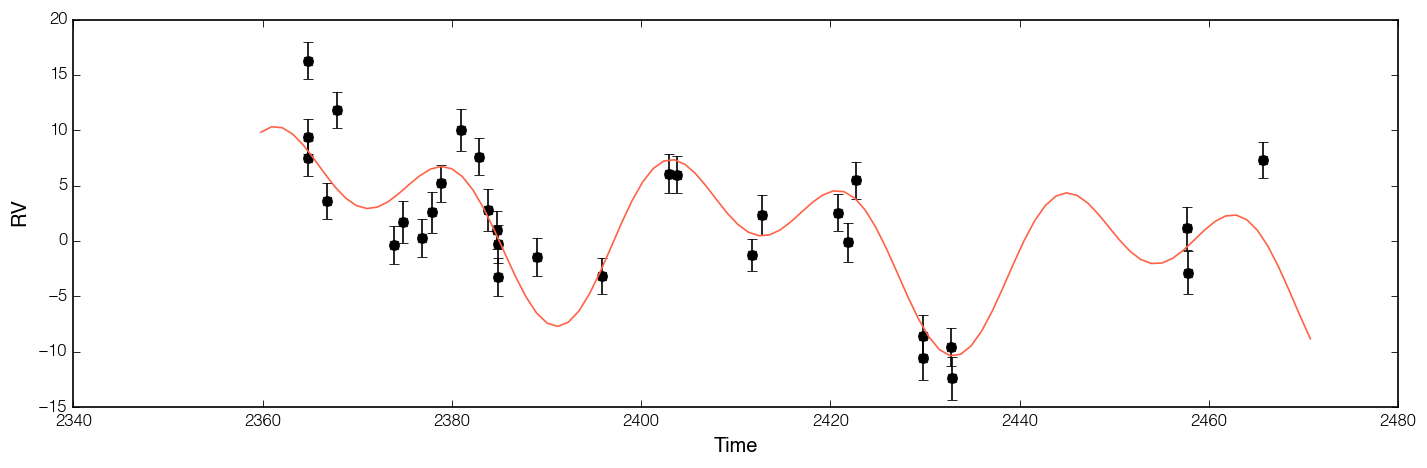

In [24]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)

like.params['gamma'] = 0.0
like.params['logjit'] = np.log(1)
like.vary['secosw1'] = False
like.vary['sesinw1'] = False
like.vary['secosw2'] = False
like.vary['sesinw2'] = False
like.vary['per1'] = False
like.vary['per2'] = False
like.vary['tc1'] = False
like.vary['tc2'] = False

post = radvel.posterior.Posterior(like)
#post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'logjit', log(3), 0.5)]

#plot_results(like) # Plot initial model
#res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='L-BFGS-B' ,options=dict(epsilon=1e-4))
print res
#print like_syn
fig = figsize(12,4)
plot_results(like) # plot best fit model
print post

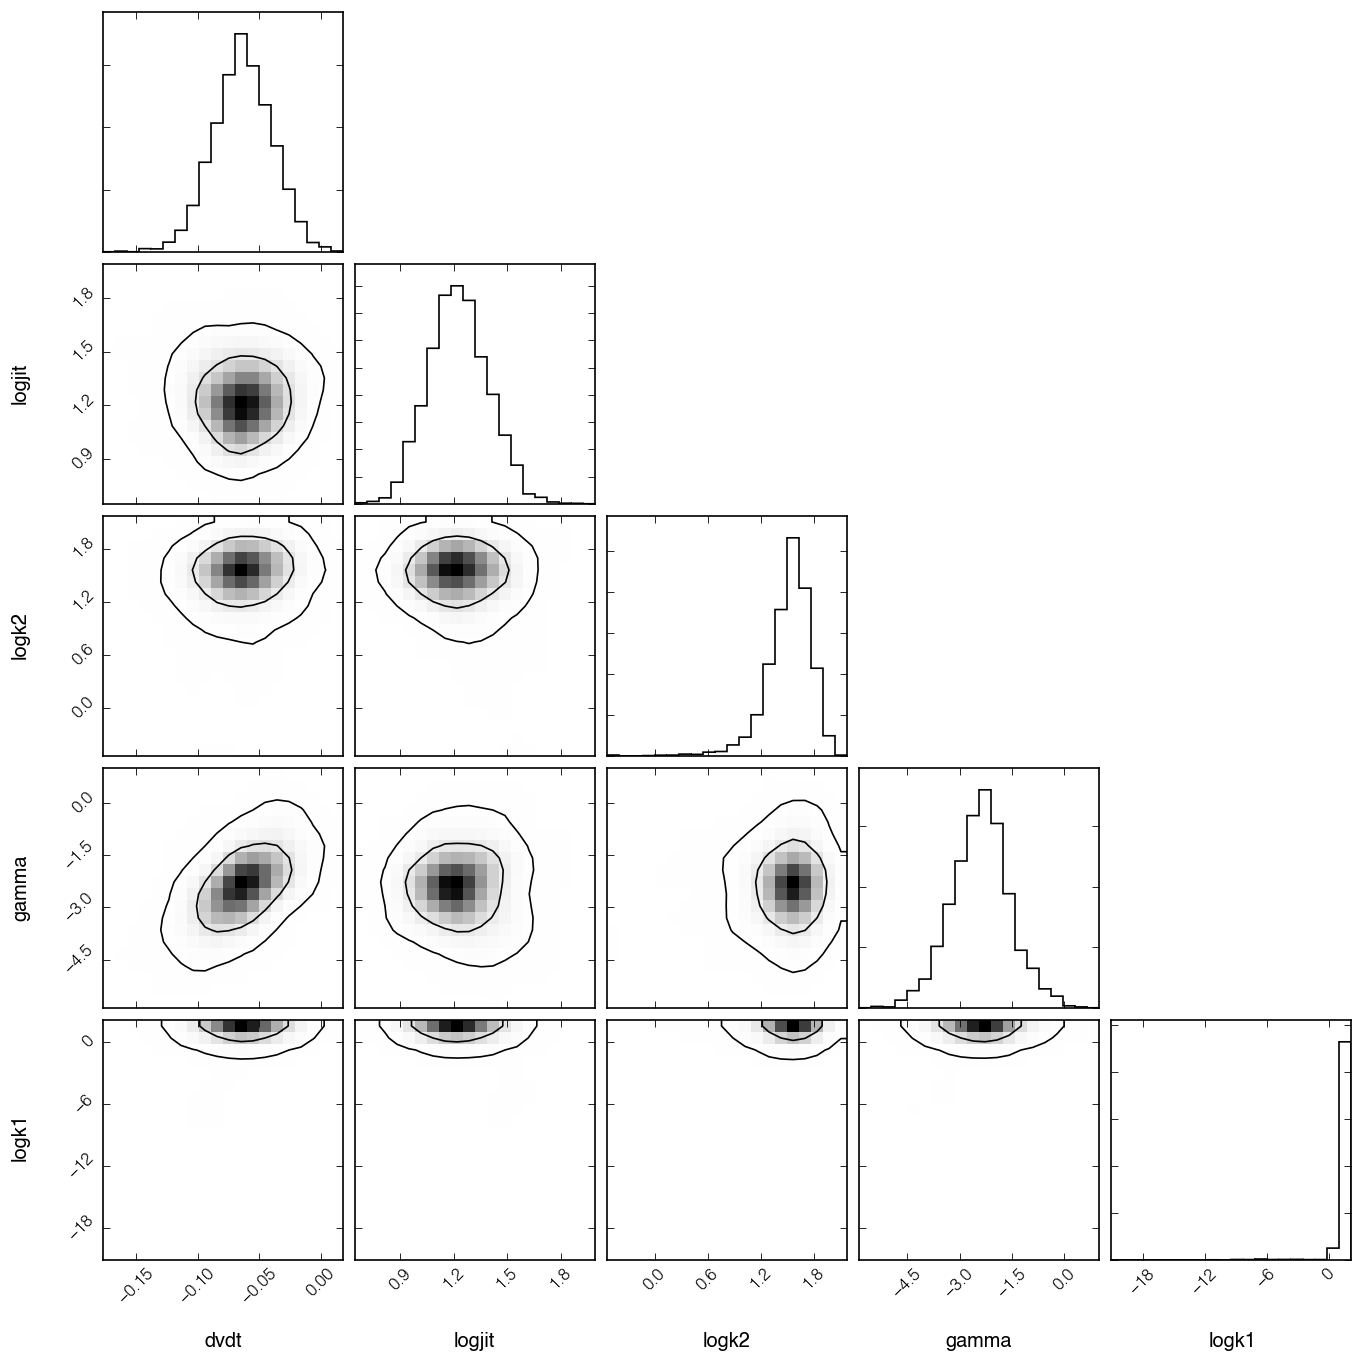

In [25]:
df = radvel.mcmc(post,threads=1,nburn=100,nwalkers=20,nrun=500)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

Fit EPIC-2307 light curve
=========================
1. eccentric orbits
2. fixed period, time of transit

  status: 1
    nfev: 1800
 success: False
     fun: 82.956847524269676
       x: array([ 0.17390598,  0.39827378,  1.03893435, -0.0076487 , -2.53382645,
        2.04658832,  0.17319093, -0.62456042,  1.70904131])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 1263
parameter                value       vary
dvdt                -0.0076487       True
gamma                 -2.53383       True
logjit                 1.03893       True
logk1                  1.70904       True
logk2                  2.04659       True
per1                   20.8851      False
per2                   42.3638      False
secosw1               0.398274       True
secosw2               0.173906       True
sesinw1               0.173191       True
sesinw2               -0.62456       True
tc1                     2072.8      False
tc2                    2082.62      False
Priors
------
Generic Prior
Gaussian Prior on logjit, mu=1.09861228867, sigma=1



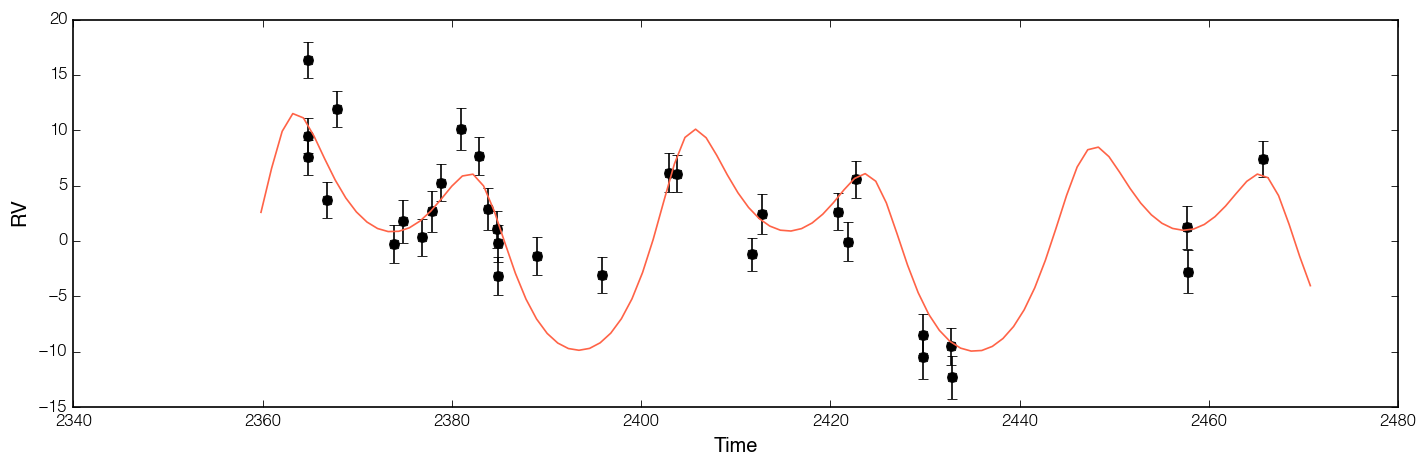

In [26]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, array(rv.t), array(rv.vel), array(rv.errvel))

like.params['gamma'] = 0.1
like.params['logjit'] = np.log(2)
like.vary.update(per1=False,per2=False,tc1=False,tc2=False)
like.params.update(secosw1=0.1,sesinw1=0.1,secosw2=0.1,sesinw2=0.1)

post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'logjit', log(3),1)]

#plot_results(like) # Plot initial model
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='L-BFGS-B' )
print res
#print like_syn
plot_results(like) # plot best fit model
print post

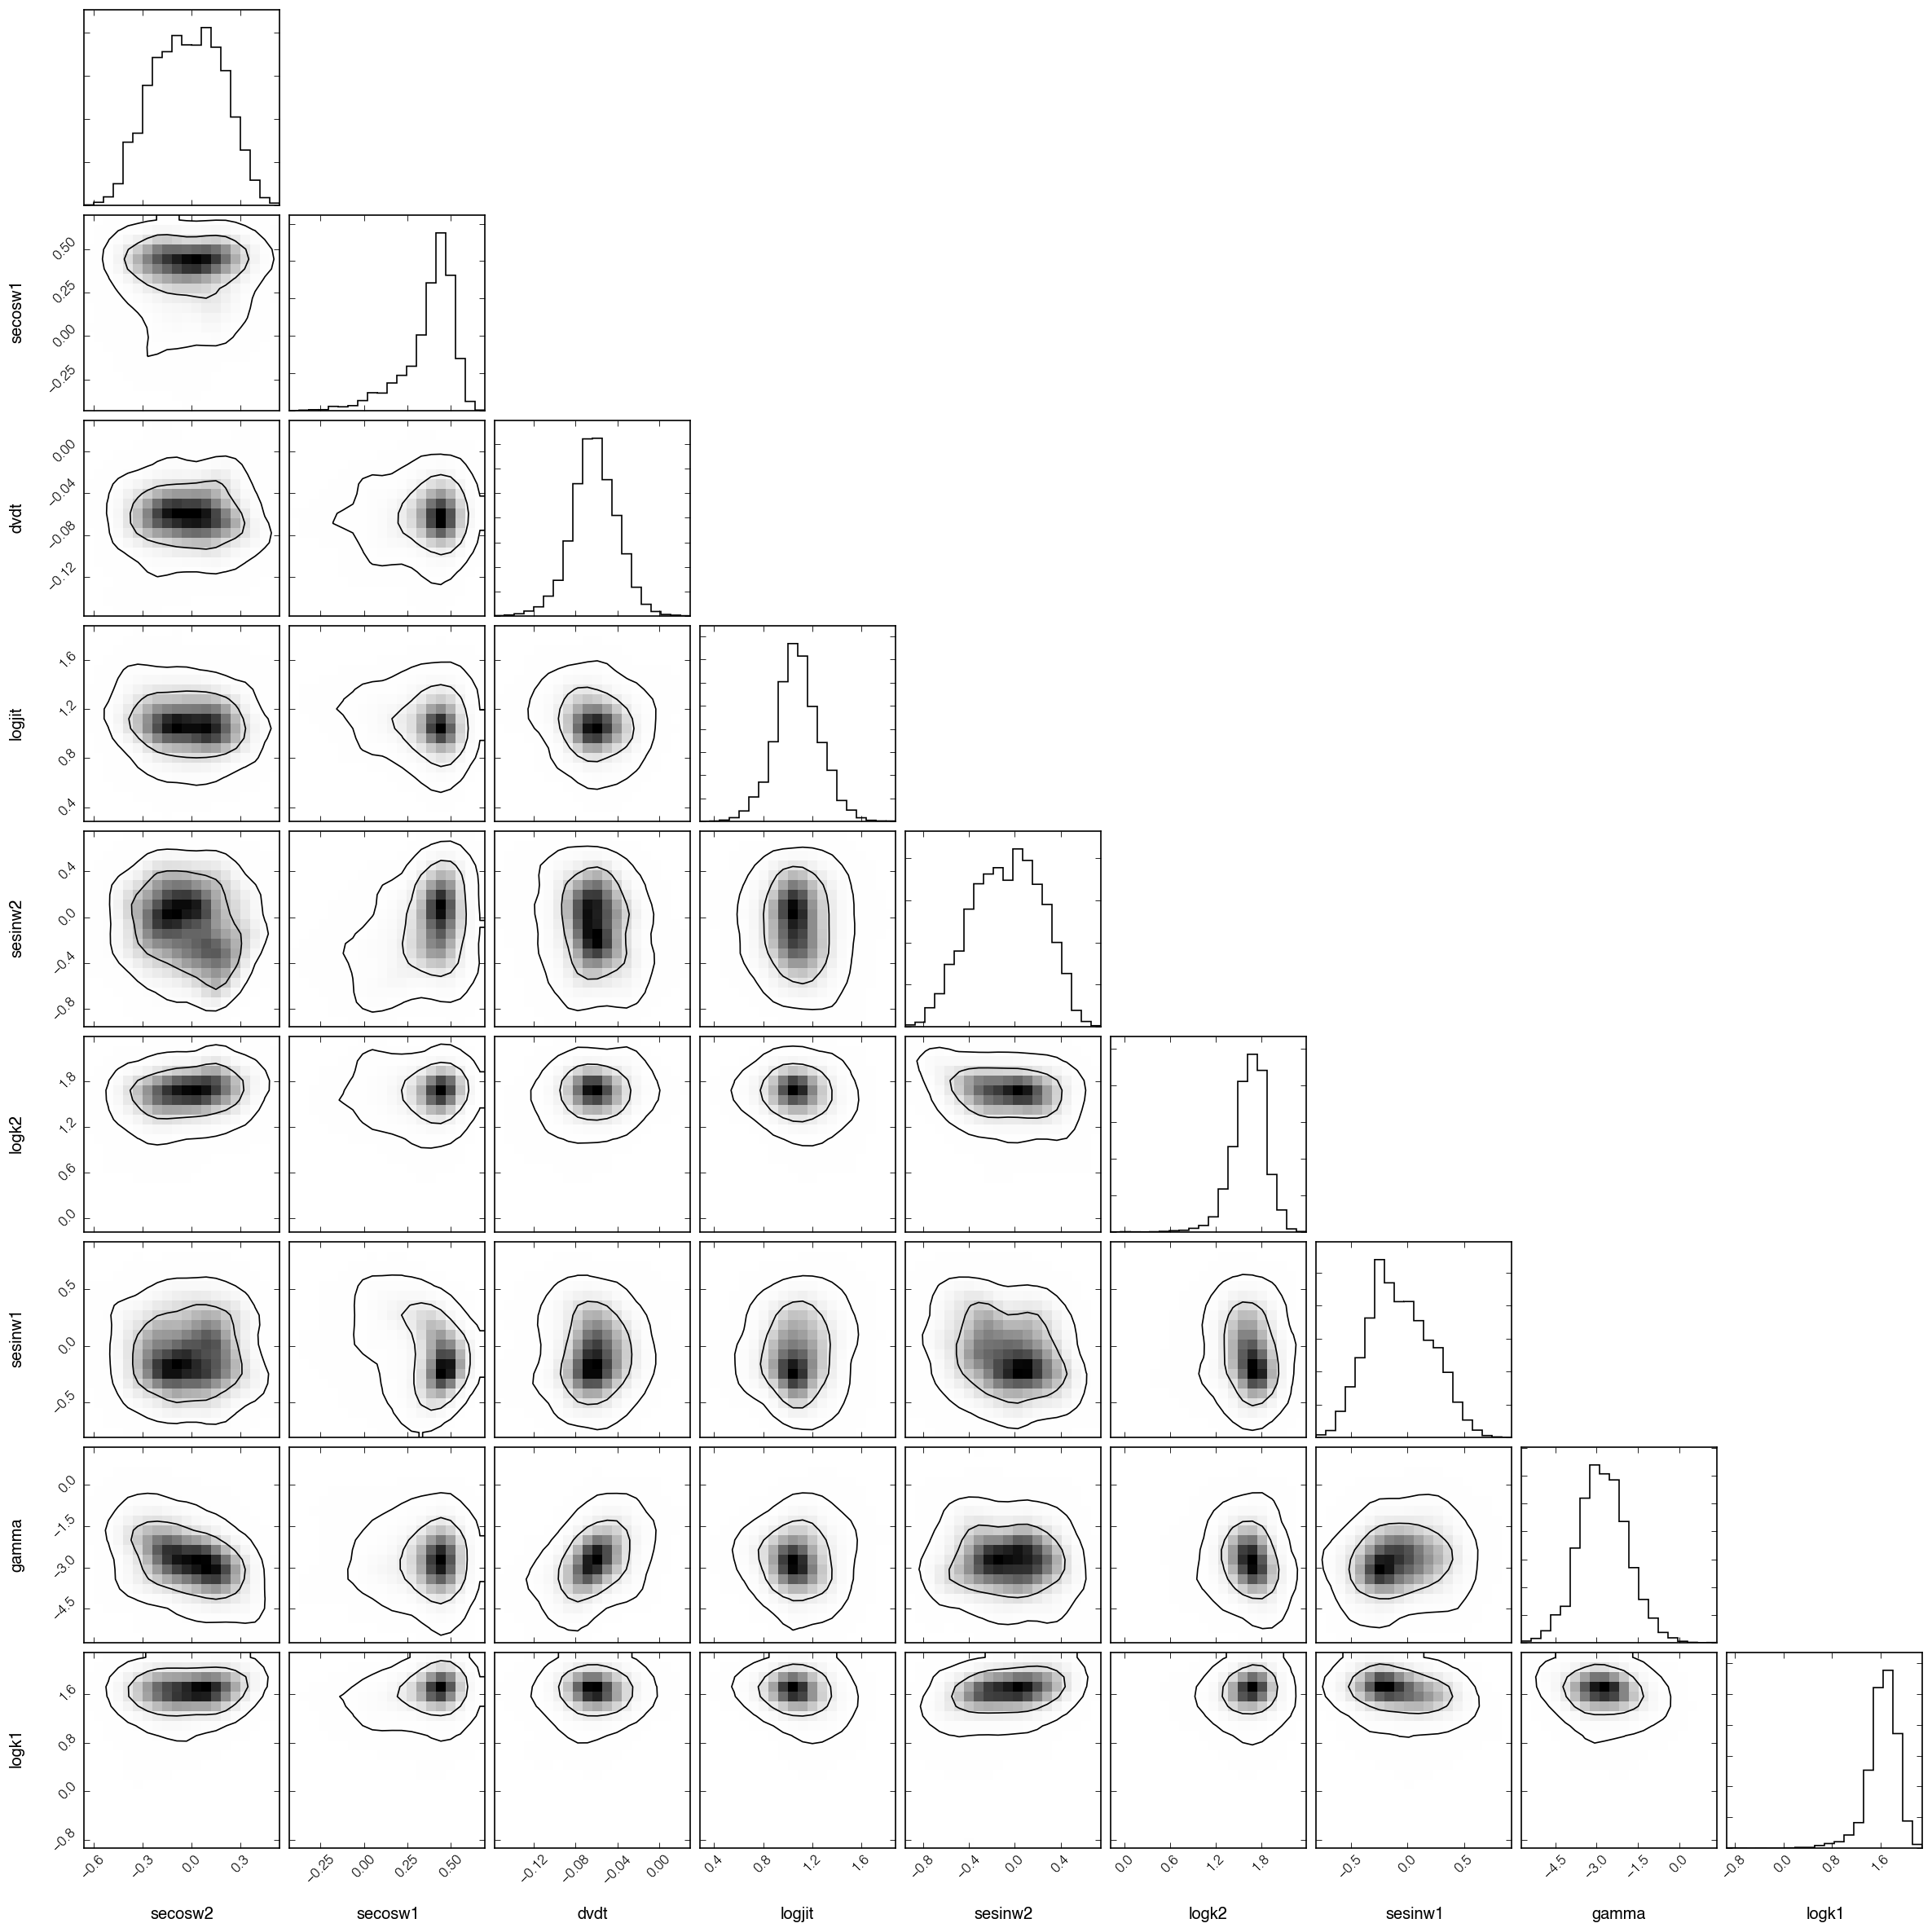

In [27]:
df = radvel.mcmc(post,threads=1,nburn=1000,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

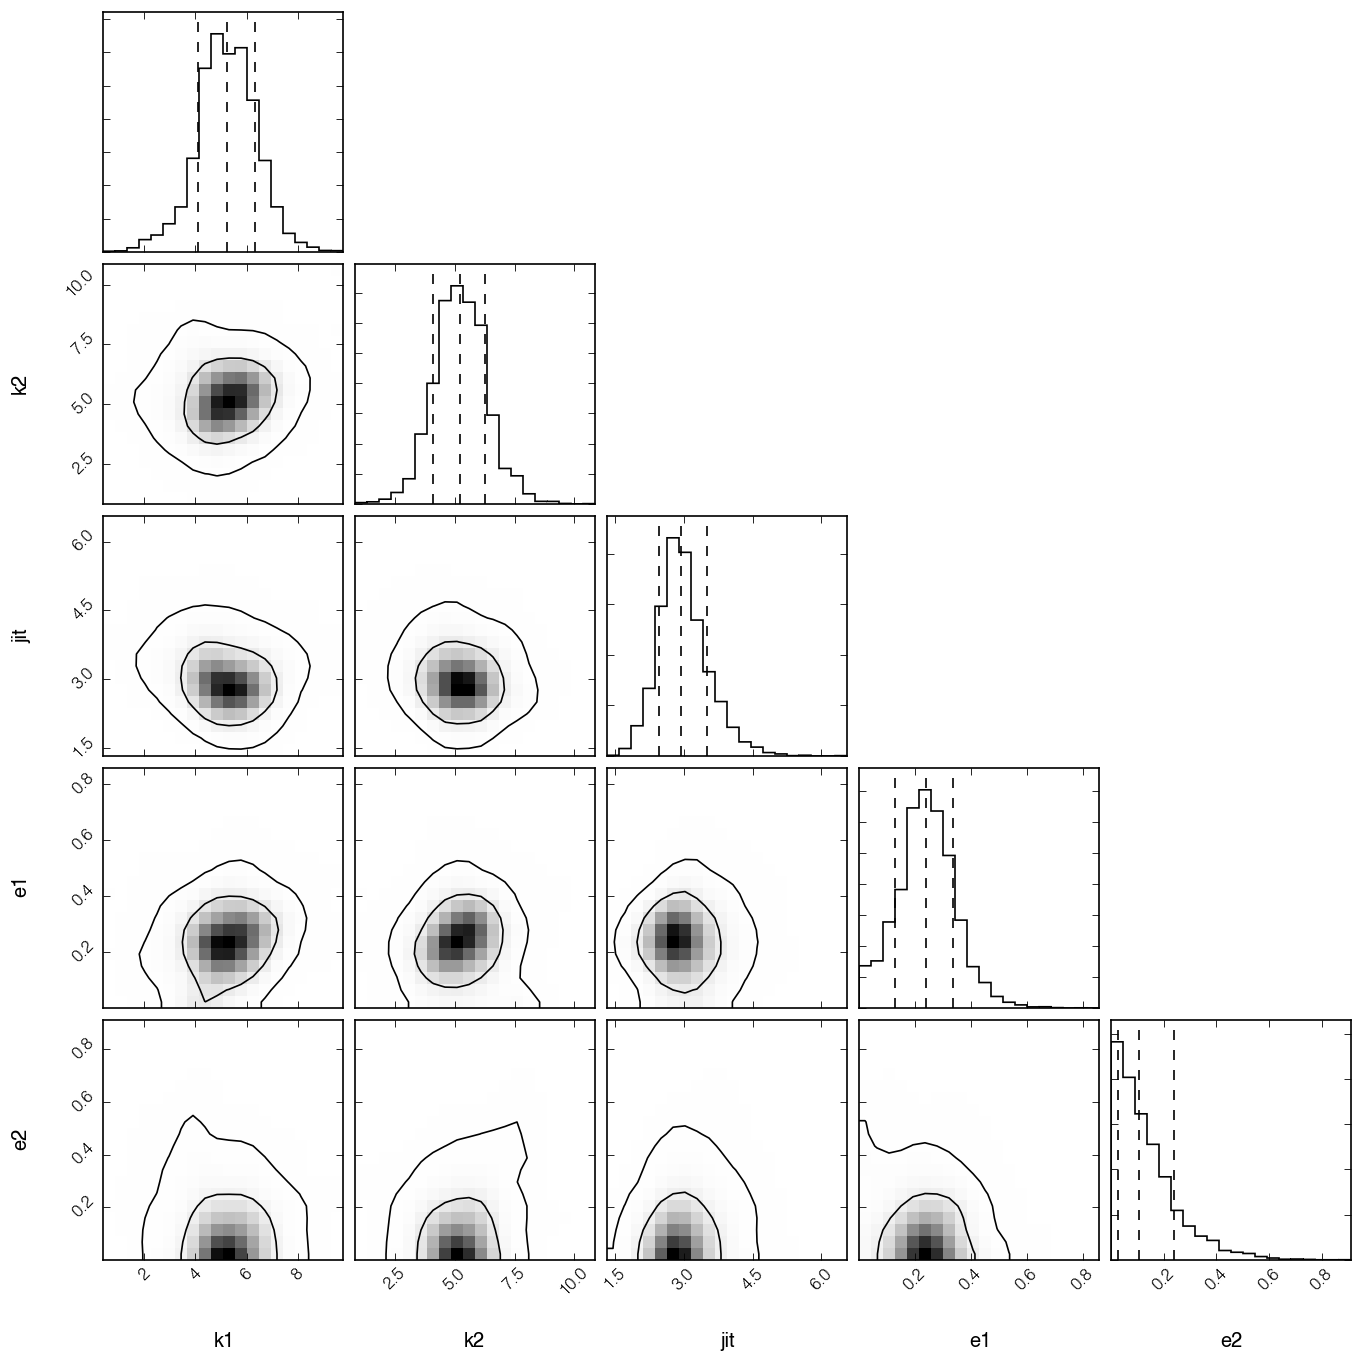

In [28]:
df['k1'] = exp(df['logk1'])
df['k2'] = exp(df['logk2'])
df['jit'] = exp(df['logjit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])


labels = 'k1 k2 jit e1 e2'.split()
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20,quantiles=[.14,.5,.84]
    )

In [29]:
df[labels].describe()

,k1,k2,jit,e1,e2
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,5.222363,5.242904,2.997010,0.240512,0.136313
std,1.170384,1.112959,0.555727,0.103950,0.119612
min,0.394877,0.829747,1.328311,0.000084,0.000032
25%,4.499153,4.528026,2.632649,0.176109,0.047350
50%,5.218426,5.210020,2.935451,0.238741,0.107294
75%,5.997133,5.962710,3.296454,0.305331,0.189855
max,9.764753,10.863365,6.556925,0.858502,0.909979
